Training samples:   215731
Validation samples: 27328
Input shape: torch.Size([40])
Label: tensor(0.2949)


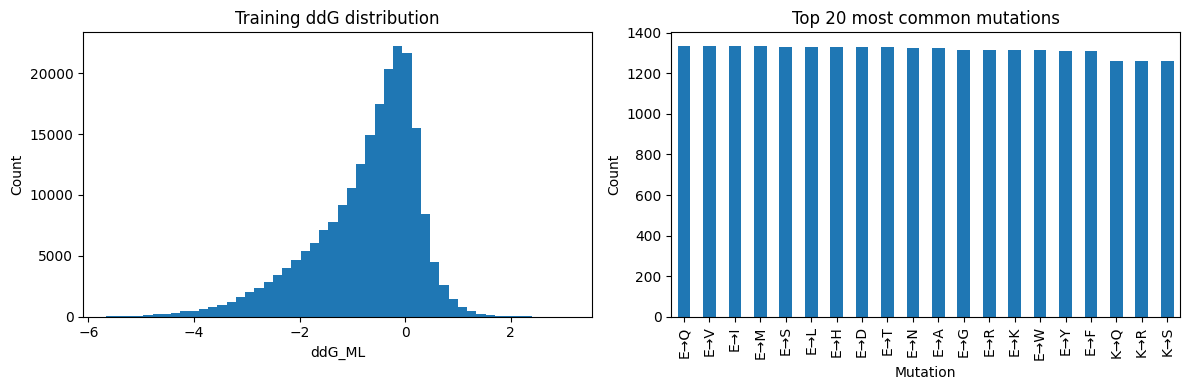

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | FLOPs
-------------------------------

Mean ddG: -0.7434021205072276
Std  ddG: 1.002267851466643
Min  ddG: -5.662801740183
Max  ddG: 3.0994431839723564


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/course/bc_NN/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


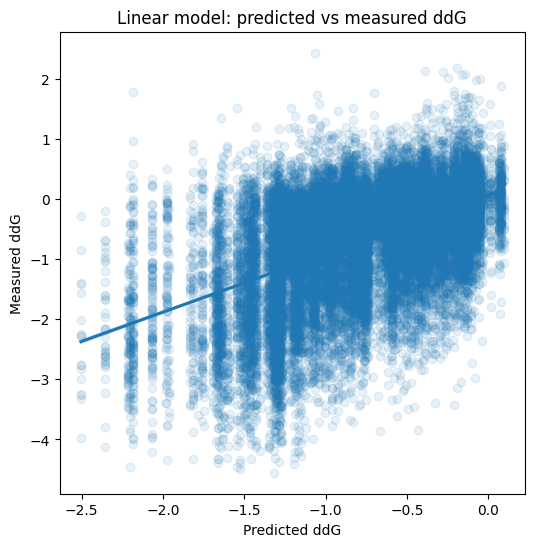

RMSE:       0.640953779220581
Pearson r:  PearsonRResult(statistic=0.510047, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.474361622817044, pvalue=0.0)


In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import sklearn.metrics as skmetrics

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

# Amino acid alphabet and encoding
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_int   = {aa: i for i, aa in enumerate(aa_alphabet)}

class FlatMutationDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        # remove wild type rows
        self.df = self.df[self.df.mut_type != 'wt'].reset_index(drop=True)
        # extract wt and mut amino acids from mut_type string e.g. 'E1Q'
        self.df['wt_aa']  = self.df['mut_type'].apply(lambda x: x[0])
        self.df['mut_aa'] = self.df['mut_type'].apply(lambda x: x[-1])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # one-hot encode wt and mutant amino acid
        wt_oh  = torch.zeros(20)
        mut_oh = torch.zeros(20)
        wt_oh[aa_to_int[row['wt_aa']]]   = 1
        mut_oh[aa_to_int[row['mut_aa']]] = 1
        # concatenate to 40-dimensional input vector
        x = torch.cat([wt_oh, mut_oh])
        y = torch.tensor(row['ddG_ML'], dtype=torch.float32)
        return x, y

# Load datasets
dataset_train = FlatMutationDataset('data/mega_train.csv')
dataset_val   = FlatMutationDataset('data/mega_val.csv')

loader_train  = DataLoader(dataset_train, batch_size=256, shuffle=True,  num_workers=4)
loader_val    = DataLoader(dataset_val,   batch_size=256, shuffle=False, num_workers=4)

# quick sanity check
print("Training samples:  ", len(dataset_train))
print("Validation samples:", len(dataset_val))
x_sample, y_sample = dataset_train[0]
print("Input shape:", x_sample.shape)   # should be (40,)
print("Label:", y_sample)               # should be a flo

# Data exploration
train_df = pd.read_csv('data/mega_train.csv')
train_df = train_df[train_df.mut_type != 'wt']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(train_df['ddG_ML'], bins=50)
axes[0].set_xlabel('ddG_ML')0.510
axes[0].set_ylabel('Count')
axes[0].set_title('Training ddG distribution')

# mutation type counts
mut_counts = train_df['mut_type'].apply(lambda x: x[0] + '→' + x[-1])
mut_counts.value_counts().head(20).plot(kind='bar', ax=axes[1])
axes[1].set_title('Top 20 most common mutations')
axes[1].set_xlabel('Mutation')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("Mean ddG:", train_df['ddG_ML'].mean())
print("Std  ddG:", train_df['ddG_ML'].std())
print("Min  ddG:", train_df['ddG_ML'].min())
print("Max  ddG:", train_df['ddG_ML'].max())

# Model
class MutationLinear(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr
        # single linear layer: 40 inputs → 1 output0.510
        self.linear  = nn.Linear(40, 1)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.linear(x).squeeze(1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = self.loss_fn(self(x), y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        loss = self.loss_fn(self(x), y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)


# Train
model   = MutationLinear(lr=1e-3)
trainer = L.Trainer(devices=1, max_epochs=20)
trainer.fit(model, loader_train, loader_val)


# Evaluate
model.eval()
preds = []
all_y = []

with torch.no_grad():
    for batch in loader_val:
        x, y  = batch
        y_hat = model(x)
        preds.append(y_hat.detach().numpy())
        all_y.append(y.detach().numpy())

preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

# plot
plt.figure(figsize=(6, 6))
sns.regplot(x=preds, y=all_y, scatter_kws={'alpha': 0.1})
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")
plt.title("Linear model: predicted vs measured ddG")
plt.show()

# metricsd-work
print("RMSE:      ", skmetrics.mean_squared_error(all_y, preds))#, squared=False))
print("Pearson r: ", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))